In [396]:
import pandas as pd
import numpy as np
import math, sys
import matplotlib.pyplot as plt

In [397]:
plt.rc('font', size=18); plt.rcParams['figure.constrained_layout.use'] = True
df = pd.read_csv('Datasets/preprocessed-dataset/preproc_data.csv')

In [398]:
df_site_info = pd.read_csv('Datasets/traffic_volumes_site_metadata_jan_jun_2020/its_scats_sites_aug-2020.csv')
CITY_CENTER = df_site_info.Region == "CCITY"
df_site_info = df_site_info[CITY_CENTER]

In [411]:
#Train models for these sites and evaluate
# High Traffic Volume Sites: 628,305,2
# Medium Traffic Sites: 48,36,420,3
# Low Traffic Sites : 796, 1,402, 665
SITES_LIST = [628,305,2,48,36,420,3,796, 1,402,665]
# sites_df_dict = {}
sites_df_list = list()

for count, site in enumerate(SITES_LIST):
    site_id = df.Site == site
    df_site = df[site_id]
    # sites_df_dict[count] = df_site
    sites_df_list.append(df_site)

SITE_1 = df.Site == 1
df_site_1 = df[SITE_1]
print(df_site_1)

              End_Time Region  Site  Average_volume_of_all_detectors  \
0        1/1/2020 1:00  CCITY     1                                9   
113      1/1/2020 2:00  CCITY     1                                7   
170      1/1/2020 4:00  CCITY     1                                5   
261      1/1/2020 3:00  CCITY     1                                5   
452      1/1/2020 6:00  CCITY     1                                2   
...                ...    ...   ...                              ...   
436139  6/3/2020 23:00  CCITY     1                                3   
436326   6/4/2020 0:00  CCITY     1                                3   
436443   6/1/2020 8:00  CCITY     1                                2   
436650   6/1/2020 9:00  CCITY     1                                3   
436683  6/1/2020 10:00  CCITY     1                                3   

        precipitation_amount_(mm)   air_temperature_(C)  
0                              0.0                  6.9  
113                

In [400]:
# convert date/time to unix timestamp in sec
all_timestamps_in_sec =pd.array((pd.DatetimeIndex(df_site_1.iloc[:,0])).astype(np.int64))/1000000000
time_sampling_interval = all_timestamps_in_sec[1] - all_timestamps_in_sec[0]
print("data sampling interval is %d secs"%time_sampling_interval)

data sampling interval is 3600 secs


C:\Users\adish\AppData\Local\Temp/ipykernel_21532/1260594523.py:2: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  all_timestamps_in_sec =pd.array((pd.DatetimeIndex(df_site_1.iloc[:,0])).astype(np.int64))/1000000000


<PandasArray>
[                 0.0, 0.041666666666666664,                0.125,
  0.08333333333333333,  0.20833333333333334,  0.16666666666666666,
   0.3333333333333333,                 0.25,   0.2916666666666667,
                0.375,
 ...
   154.70833333333334,   154.70833333333334,              154.875,
               154.75,   154.79166666666666,   154.91666666666666,
   154.95833333333334,   152.29166666666666,   152.33333333333334,
              152.375]
Length: 3736, dtype: float64
[9 7 5 ... 2 3 3]


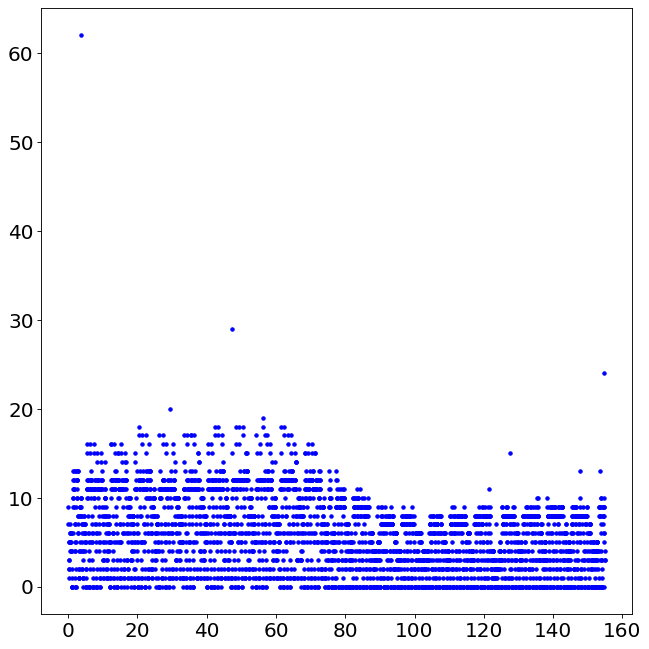

In [401]:
timestamps_in_days=(all_timestamps_in_sec-all_timestamps_in_sec[0])/60/60/24 # convert timestamp to days
print(timestamps_in_days)
y_output_avg_vol_cars = np.extract(all_timestamps_in_sec,df_site_1.iloc[:,3]).astype(np.int64)
print(y_output_avg_vol_cars)
# plot extracted data
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(timestamps_in_days,y_output_avg_vol_cars, color='blue', marker='.'); plt.show()

In [408]:
#dd is trend or seasonality
#lag is number of points
#q is step size
def test_preds(q,dd,lag, plot):
    #q-step ahead prediction
    stride=1
    XX=y_output_avg_vol_cars[0:y_output_avg_vol_cars.size-q-lag*dd:stride]
    print(f'XX.shape {XX.shape}')
    print(f'y_output_avg_vol_cars.size {y_output_avg_vol_cars.size}')
    print(f'y_output_avg_vol_cars.size-q {y_output_avg_vol_cars.size-q}')
    print(f'lag*dd {lag*dd}')
    print(f'y_output_avg_vol_cars.size-q-lag*dd {y_output_avg_vol_cars.size-q-lag*dd}')
    for i in range(1,lag):
        print(i)
        X=y_output_avg_vol_cars[i* dd:y_output_avg_vol_cars.size-q-(lag-i)* dd:stride]
        print(X)
        XX=np.column_stack((XX,X))
        print(XX)
    yy=y_output_avg_vol_cars[lag* dd+q::stride]; tt=timestamps_in_days[lag* dd+q::stride]
    from sklearn.model_selection import train_test_split
    train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)
    from sklearn.linear_model import Ridge
    model = Ridge(fit_intercept=False).fit(XX[train], yy[train])
    print(model.intercept_, model.coef_)
    if plot:
        y_pred = model.predict(XX)
        plt.scatter(timestamps_in_days, y_output_avg_vol_cars, color='black'); plt.scatter(tt, y_pred, color='blue')
        plt.xlabel("time (days)"); plt.ylabel("#volume of cars")
        plt.legend(["training data","predictions"],loc='upper right')
        day=math.floor(24*60*60/time_sampling_interval) # number of samples per day
        plt.xlim(((lag*dd+q)/day,(lag*dd+q)/day+2))
        plt.show()

XX.shape (3723,)
y_output_avg_vol_cars.size 3736
y_output_avg_vol_cars.size-q 3726
lag*dd 3
y_output_avg_vol_cars.size-q-lag*dd 3723
1
[7 5 5 ... 0 8 9]
[[ 9  7]
 [ 7  5]
 [ 5  5]
 ...
 [10  0]
 [ 0  8]
 [ 8  9]]
2
[5 5 2 ... 8 9 8]
[[ 9  7  5]
 [ 7  5  5]
 [ 5  5  2]
 ...
 [10  0  8]
 [ 0  8  9]
 [ 8  9  8]]
0.0 [0.19454185 0.14572107 0.23744684]


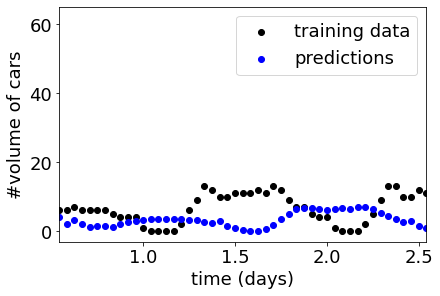

In [410]:
# prediction using short-term trend
plot=True
test_preds(q=10,dd=1,lag=3,plot=plot)

# # prediction using daily seasonality
# d=math.floor(24*60*60/time_sampling_interval) # number of samples per day
# test_preds(q=d,dd=d,lag=3,plot=plot)
#
# # # prediction using weekly seasonality
# w=math.floor(7*24*60*60/time_sampling_interval) # number of samples per week
# test_preds(q=w,dd=w,lag=3,plot=plot)

0.0 [ 3.80860943e-04  2.45029984e-01  5.67769309e-01  3.80860943e-04
  1.90895206e-02  1.88745120e-02 -2.90926597e-02  1.50901379e-03
  9.84637040e-02]


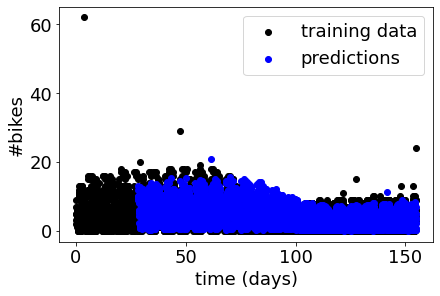

In [404]:
#putting it together
q=10
lag=3; stride=1
w=math.floor(7*24*60*60/time_sampling_interval) # number of samples per week
len = y_output_avg_vol_cars.size-w-lag*w-q
XX=y_output_avg_vol_cars[q:q+len:stride]
for i in range(1,lag):
    X=y_output_avg_vol_cars[i*w+q:i*w+q+len:stride]
    XX=np.column_stack((XX,X))
    d=math.floor(24*60*60/time_sampling_interval) # number of samples per day
for i in range(0,lag):
    X=y_output_avg_vol_cars[i*d+q:i*d+q+len:stride]
    XX=np.column_stack((XX,X))
for i in range(0,lag):
    X=y_output_avg_vol_cars[i:i+len:stride]
    XX=np.column_stack((XX,X))
    yy=y_output_avg_vol_cars[lag*w+w+q:lag*w+w+q+len:stride]
    tt=timestamps_in_days[lag*w+w+q:lag*w+w+q+len:stride]
from sklearn.model_selection import train_test_split
train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)
#train = np.arange(0,yy.size)
from sklearn.linear_model import Ridge
model = Ridge(fit_intercept=False).fit(XX[train], yy[train])
print(model.intercept_, model.coef_)

if plot:
    y_pred = model.predict(XX)
    plt.scatter(timestamps_in_days, y_output_avg_vol_cars, color='black'); plt.scatter(tt, y_pred, color='blue')
    plt.xlabel("time (days)"); plt.ylabel("#bikes")
    plt.legend(["training data","predictions"],loc='upper right')
    day=math.floor(24*60*60/time_sampling_interval) # number of samples per day
    # plt.xlim((4*7,4*7+4))
    plt.show()


In [405]:
# TODO:
# Cross-Validation -kFold or timeseries split
# Using sites as features
# Different Model implementations
# Using weather features
# Include Collab Plots
# Evaluation
# Report